(stability-chapter)=
# Stability

**Learning outcomes**

On successful completion of this chapter readers will be able to:

- understand what it means for a method to be considered [stable](stability-definition);
- understand what is means when a problem is [stiff](stiffness-section) and calculate the [stiffness ratio](stiffness-ratio-definition);
- determine the [stability function](stability-function-definition) of [explicit](erk-rz-definition
) and [implicit](irk-rz-definition) Runge-Kutta methods;
- understand what it means when a method is [absolutely stable](absolute-stability-definition);
- plot the [region of absolute stability](plot-stability-region-section) and use it to identify the [interval of absolute stability](plot-stability-region-section) for a Runge-Kutta method;
- understand what it means when a method is [A-stable](a-stability-definition) and determine whether a method is A-stable or not.

---

## Stable and unstable solutions

The Euler method has been applied to solve the following initial value problem using step lengths of $h = 0.25$ and $h = 0.125$

\begin{align*}
    y' = -15y, \qquad t \in [0, 5], \qquad y(0) = 1.
\end{align*}

The exact solution is $y = e^{-15t}$ and the numerical solutions are plotted against the exact solution in {numref}`stiff-solution-1`. Here we can see that the solution using $h = 0.125$ remains bounded whereas the solution using $h = 0.25$ diverges.

```{glue:figure} stiff_solution_1
:name: "stiff-solution-1"

Stable and unstable solutions to the initial value problem $y' = -15y$, $t\in [0, 5]$ and $y(0) = 1$.
```

The solution using $h = 0.125$ is an example of a **stable** solution and the solution using $h = 0.25$ is an example of an **unstable** solution. The reason for the instability is due to the truncation of the Taylor series. We saw in the section on [error analysis](error-analysis-section) that the higher order terms that are omitted due to truncation causes a [local truncation error](lte-definition), $\tau$, and the accumulation of these local truncation errors creates the [global truncation error](gte-definition). If the local truncation error is too large then the global truncation error will eventually diverge as seen in {numref}`stiff-solution-1` causing the solution to be unusable. This provides us with the definition of stability. 

````{admonition} Definition: stability
:class: note
:name: stability-definition

If $\tau_n$ is the local truncation error of a numerical method defined by

\begin{align*}
    \tau_n = |y_n - \bar{y}_n|,
\end{align*}
   
where $y_n$ is the exact solution and $\bar{y}_n$ the numerical approximation then the method is considered **stable** if

```{math}
:label: stability-equation

|\tau_{n+1} - \tau_n | \leq 1,
```

for all steps of the method. If a method is not stable then it is **unstable**.
````

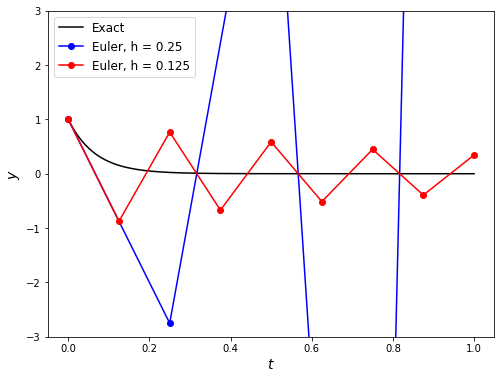

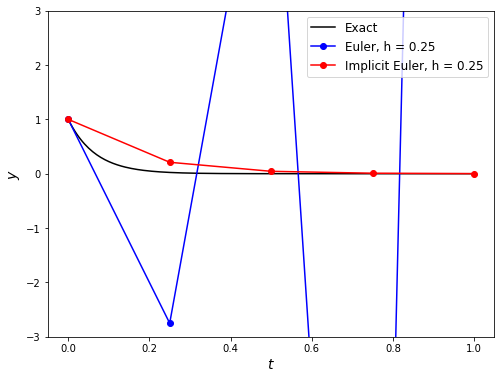

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def euler(f, tspan, y0, h):
    nsteps, neq = int((tspan[1] - tspan[0]) / h), len(y0)
    t = np.arange(nsteps + 1) * h
    y = np.zeros((nsteps + 1, neq))
    y[0,:] = y0
    for n in range(nsteps):
        y[n+1,:] = y[n,:] + h * f(t[n], y[n,:])
        
    return t, y 


def implicit_euler(f, tspan, y0, h):
    nsteps, neq = int((tspan[1] - tspan[0]) / h), len(y0)
    t = np.arange(nsteps + 1) * h
    y = np.ones((nsteps + 1, neq))
    y[0,:] = y0
    for n in range(nsteps):
        y[n+1,:] = y[n,:] / (1 + 15 * h)
        
    return t, y 

      
def f(t, y):
    return -15 * y


def exact(t):
    return np.exp(-15 * t)


# Define IVP parameters
tspan = [0, 1]  # boundaries of the t domain
y0 = [1]        # solution at the lower boundary
h = 0.7         # step length
tol = 1e-6      # convergence tolerance

# Calculate the solution to the IVP
t_euler1, y_euler1 = euler(f, tspan, y0, 0.25)
t_euler2, y_euler2 = euler(f, tspan, y0, 0.125)
t_euler3, y_euler3 = implicit_euler(f, tspan, y0, 0.25)

# Plot solution
t_exact = np.linspace(tspan[0], tspan[1], 200)
y_exact = exact(t_exact)
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(t_exact, y_exact, "k", label="Exact")
plt.plot(t_euler1, y_euler1, "bo-", label="Euler, h = 0.25")
plt.plot(t_euler2, y_euler2, "ro-", label="Euler, h = 0.125")
plt.ylim([-3, 3])
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.legend(fontsize=12)
plt.show()

from myst_nb import glue
glue("stiff_solution_1", fig, display=False)

# Plot solution
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(t_exact, y_exact, "k", label="Exact")
plt.plot(t_euler1, y_euler1, "bo-", label="Euler, h = 0.25")
plt.plot(t_euler3, y_euler3, "ro-", label="Implicit Euler, h = 0.25")
plt.ylim([-3, 3])
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.legend(fontsize=12)
plt.show()

from myst_nb import glue
glue("stiff_solution_2", fig, display=False)

(stiffness-section)=
## Stiffness

Whether a numerical method used to solve an ODE is stable or unstable depends upon the ODE being solved and the step length used. A method could be stable for one ODE using a particular step length and unstable for another using the same step length. ODEs that require particularly small step length for a method to be stable are known as **stiff** ODEs. There is no mathematical definition of what makes an ODE stiff, however, a useful description is provided by {cite:t}`lambert:1991`

>*If a numerical method with a finite region of absolute stability, applied to a system with any initial conditions, is forced to use in a certain interval of integration a step length which is excessively small in relation to the smoothness of the exact solution in that interval, then the system is said to be stiff in that interval.*

### Stiffness ratio

Consider a system of linear ODEs for the form

\begin{align*}
    \mathbf{y}' = A \mathbf{y},
\end{align*}

where $\mathbf{y} = (y_1, y_2, \ldots, y_n)^T$ and $A$ is an $n \times n$ matrix of constants. Let $V = (\mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_n)$ be a matrix containing the [eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of $A$ then

$$V = (A \mathbf{v}_1, A \mathbf{v}_2, \ldots, A \mathbf{v}_n).$$

Since $A \mathbf{v}_i = \lambda_i \mathbf{v}_1$ where $\lambda_i$ is the eigenvalue corresponding to the eigenvector $\mathbf{v}_i$ then

\begin{align*}
    AV = (\lambda_1 \mathbf{v}_1, \lambda_2 \mathbf{v}_2, \ldots, \lambda_n \mathbf{v}_n) = V \Lambda
\end{align*}

where $\Lambda$ is a diagonal matrix of the eigenvalues $\lambda_i$ (take care to make the distinction between $\Lambda$ which is the the uppercase $\lambda$ character and A). Multiplying both sides by $V^{-1}$ gives

\begin{align*}
    V^{-1} A V = \Lambda,
\end{align*}

which means that $V^{-1} A$ is a linear transformation that that **diagonalises** the matrix $A$. Let $\mathbf{u} = V^{-1} A \mathbf{y}$ then we have the transformed system $\mathbf{u}' = \Lambda \mathbf{u}$ which is

\begin{align*}
    u_1' &= \lambda_1 u_1, \\
    u_2' &= \lambda_2 u_2, \\
    &\vdots \\
    u_n' &= \lambda_n u_n.
\end{align*}

Each equation in the transformed system has the solution $u_i = e^{\lambda_i t}$ so the fastest growing solution will be for the equation with the largest value of $\lambda$ and the slowest growing solution will be for the equation with the smallest value of $\lambda$. Stiffness occurs when there is a large variation in the solutions of equations in a system so we can gauge this by calculating the ratio between the largest and smallest eigenvalues of $A$. 

````{admonition} Definition: stiffness ratio
:class: note
:name: stiffness-ratio-definition

The **stiffness ratio** for a system of ODEs of the form $\mathbf{y}' = A \mathbf{y}$ is
```{math}
S = \frac{\max_i(|\lambda_i|)}{\min_i(|\lambda_i|)}
```
where $\lambda_i$ are the eigenvalues of $A$.
````

If the stiffness ratio of a system of ODEs is large[^1] then the system is considered to be stiff. 

[^1]: What constitutes "large" is vague and subjective. As a rule of thumb if $S$ is in the hundreds or greater we can consider the system to be stiff. 

````{admonition} Example 4.1
:class: seealso

Determine the stiffness ration of the following ODE

$$ y'' + 1001 y' + 1000 y = 0.$$

```{dropdown} Solution

Rewriting the second-order ODE as a system of two first-order ODEs

\begin{align*}
    y_1' &= y_2, \\
    y_2' &= -1000 y_1 - 1001 y_2.
\end{align*}

which can be written as the matrix equation

\begin{align*}
    \begin{pmatrix} y_1' \\ y_2' \end{pmatrix} =
    \begin{pmatrix} 0 & 1 \\ -1000 & -1001 \end{pmatrix}
    \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}.
\end{align*}

Calculating the eigenvalues of the coefficient matrix

\begin{align*}
    0 &= \begin{vmatrix} -\lambda & 1 \\ -1000 & -1001 - \lambda \end{vmatrix} 
    = \lambda^2 + 1001 \lambda + 1000 = (\lambda + 1000) (\lambda + 1),
\end{align*}

so the eigenvalues are $\lambda_1 = -1000$ and $\lambda_2 = -1$. The stiffness ratio is 

$$S = \frac{|-1000|}{|-1|} = 1000.$$

Since $S = 1000$ is large then this system is considered to be stiff. 
```
````

### Solving stiff systems

To solve a stiff system we need to chose a numerical method that will be stable for a practical value of the step length. For example, the implicit Euler method (also known as the backward Euler method)

\begin{align*}
    y_{n+1} = y_n + h f(t_{n+1}, y_{n+1}),
\end{align*}

and the solutions to the initial value problem $y' = -15y$, $t\in [0, 5]$ and $y(0) = 1$ using the Euler method and the implicit Euler method with $h=0.25$ are plotted in {numref}`stiff-solution-2`. 

```{glue:figure} stiff_solution_2
:name: stiff-solution-2

Solutions to the initial value problem $y' = -15y$, $t\in [0, 5]$ and $y(0) = 1$ using the Euler and implicit Euler method.
```

So if we were constrained with using a step length of $h=0.25$ then we could choose the implicit Euler method to solve this initial value problem. 

```{bibliography}
```